In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import pickle
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from Bio import Entrez
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [248]:
PWD = Path().cwd()
DATA = Path("../data")
IPS = DATA / "rnaseq_res_ips"
FIBRO = DATA / "rnaseq_res_fibro"
HIMORNA = DATA / "himorna_peaks"
FANTOM = DATA / "fantom_cat"
PREPROCESSING = Path("../preprocessing")
HIMORNA_INDEX = PREPROCESSING / "himorna_index"
IPS_INDEX = PREPROCESSING / "ips_deg_index"
FIBRO_INDEX = PREPROCESSING / "fibro_deg_index"
IPS_MATRICES = PREPROCESSING / "ips_matrices"
FIBRO_MATRICES = PREPROCESSING / "fibro_matrices"
IPS_FISHER = PREPROCESSING / "ips_fisher_exact_test"
FIBRO_FISHER = PREPROCESSING / "fibro_fisher_exact_test"

In [249]:
for director in DATA, IPS, FIBRO, PREPROCESSING, HIMORNA_INDEX, IPS_INDEX, FIBRO_INDEX, IPS_MATRICES, FIBRO_MATRICES, IPS_FISHER, FIBRO_FISHER:
    director.mkdir(exist_ok=True, parents=True)

## himorna peaks

In [4]:
to_peaks = HIMORNA / "Himorna_all_peaks_with_correlations_ensembl_id.tsv.gz"
himorna_peaks = pd.read_csv(
        to_peaks,
        chunksize=100000000,
        sep="\t",
        names=["hm", "lnc", "lnc_ens", "peak", "chrom", "start", "end", "gene", "gene_ens", "corr"]
    )
himorna_peaks = pd.concat(himorna_peaks)

/tmp/ipykernel_18082/237761342.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  himorna_peaks = pd.concat(himorna_peaks)


In [5]:
himorna_peaks.shape

(92208462, 10)

In [6]:
himorna_peaks["lnc"] = himorna_peaks["lnc"].astype('str')

In [7]:
himorna_peaks = himorna_peaks.drop_duplicates()
himorna_peaks = himorna_peaks.dropna(subset=["hm","lnc_ens","gene_ens"])
himorna_peaks.shape

(92208462, 10)

In [8]:
himorna_peaks["corr_sign"] = np.where(himorna_peaks["corr"] > 0, "plus", "minus")

In [9]:
himorna_peaks.head()

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr,corr_sign
0,H3K9me3,AL390961.3,ENSG00000279212,peak_391,chr1,6203922,6205912,RPL22,ENSG00000116251,-0.540072,minus
1,H3K9me3,SUGT1-DT,ENSG00000273723,peak_391,chr1,6203922,6205912,RPL22,ENSG00000116251,-0.493172,minus
2,H3K9me3,AC004148.1,ENSG00000263272,peak_391,chr1,6203922,6205912,RPL22,ENSG00000116251,-0.406290,minus
3,H3K9me3,CADM3-AS1,ENSG00000225670,peak_391,chr1,6203922,6205912,RPL22,ENSG00000116251,0.556495,plus
4,H3K9me3,PCAT19,ENSG00000267107,peak_391,chr1,6203922,6205912,RPL22,ENSG00000116251,0.473327,plus


In [253]:
list_of_hm = himorna_peaks["hm"].unique()
list_of_hm

array(['H3K9me3', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K79me2', 'H3K4me2',
       'H3K4me1', 'H3K36me3', 'H3K27ac', 'H4K20me1'], dtype=object)

In [10]:
himorna_peaks.groupby(by="hm").agg({"peak":pd.Series.nunique, "lnc_ens":pd.Series.nunique, "gene_ens":pd.Series.nunique})

,peak,lnc_ens,gene_ens
hm,,,
H3K27ac,714520,1972,107396
H3K27me3,159597,1342,90277
H3K36me3,268016,1263,100443
H3K4me1,742845,1898,113747
H3K4me2,376694,1002,81821
H3K4me3,610917,1722,98533
H3K79me2,84512,765,62557
H3K9ac,71802,1080,41943
H3K9me3,202237,1035,78459


<Axes: >

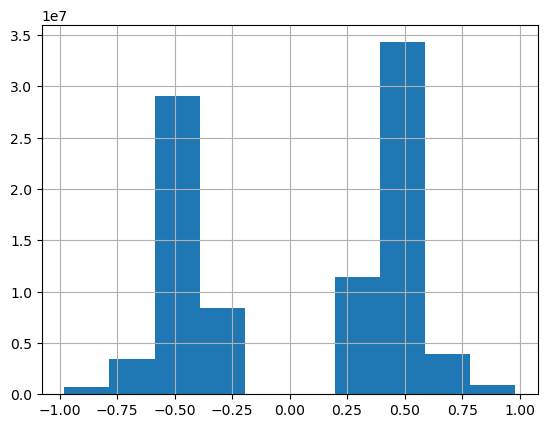

In [11]:
himorna_peaks["corr"].hist()# данные уже отфильтрованы

In [12]:
def indexing_himorna(hm, lnc_ens, corr_sign, subdf):
    to_index = HIMORNA_INDEX / hm
    to_index.mkdir(exist_ok=True, parents=True)
    to_save = to_index / f"{hm}-{lnc_ens}-{corr_sign}-.tsv.gz"
    subdf.to_csv(to_save, sep="\t", compression="gzip", index=False)    

In [13]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(indexing_himorna)(hm, lnc_ens, corr_sign, subdf)
        for (hm, lnc_ens, corr_sign), subdf in himorna_peaks.groupby(by=["hm", "lnc_ens", "corr_sign"])
    )

In [14]:
#способ смотреть без разбиаения на +/- корреляции
pd.concat([pd.read_csv(to_himorna, sep="\t") for to_himorna in HIMORNA_INDEX.glob((f'*/*-ENSG00000152931-*'))]).head()

,hm,lnc,lnc_ens,peak,chrom,start,end,gene,gene_ens,corr,corr_sign
0,H3K4me1,PART1,ENSG00000152931,peak_492441,chr2,204030106,204032803,NaN,CATG00000046296,0.696499,plus
1,H3K4me1,PART1,ENSG00000152931,peak_492441,chr2,204030106,204032803,NaN,CATG00000051310,0.696499,plus
0,H3K4me3,PART1,ENSG00000152931,peak_136574,chr12,14880482,14886882,C12orf60,ENSG00000182993,0.677999,plus
1,H3K4me3,PART1,ENSG00000152931,peak_250201,chr16,49662975,49664897,ZNF423,ENSG00000102935,0.611509,plus
2,H3K4me3,PART1,ENSG00000152931,peak_264134,chr17,9184690,9185484,NTN1,ENSG00000065320,0.572832,plus


## fantom ips deg

In [15]:
to_ips = IPS / "EdgeR.table.all.target.tsv.gz"
ips_expr = pd.read_csv(to_ips, sep="\t")
ips_expr.head()

,DEG.geneID,DEG.HGNC,EdgeR.log2FC,EdgeR.log2CPM,EdgeR.pvalue,EdgeR.FDR,EdgeR.Zscore,target.gapmerID,target.geneID,target.HGNC
0,CATG00000000155,CATG00000000155.1,0.257141,3.591144,0.550588,1.0,0.620927,G0234787_01,ENSG00000234787,LINC00458
1,CATG00000001164,CATG00000001164.1,0.706131,3.805757,0.044323,1.0,1.757448,G0234787_01,ENSG00000234787,LINC00458
2,CATG00000001318,CATG00000001318.1,-0.074655,4.766566,0.913694,1.0,0.052701,G0234787_01,ENSG00000234787,LINC00458
3,CATG00000002817,CATG00000002817.1,-0.201767,3.841792,0.716487,1.0,-0.414103,G0234787_01,ENSG00000234787,LINC00458
4,CATG00000003248,CATG00000003248.1,-0.155609,4.592817,0.650460,1.0,0.026003,G0234787_01,ENSG00000234787,LINC00458


In [16]:
ips_expr.shape

(3445156, 10)

In [17]:
ips_expr["DEG.geneID"].unique().shape

(10868,)

In [18]:
ips_expr_filt = ips_expr[(((ips_expr["EdgeR.log2FC"] < 0.5) & (ips_expr["EdgeR.Zscore"] < -1.64)) | 
                                ((ips_expr["EdgeR.log2FC"] > 0.5) & (ips_expr["EdgeR.Zscore"] > 1.64))) & 
                                (ips_expr["EdgeR.FDR"] < 0.05)]
ips_expr_filt.reset_index(inplace=True, drop=True)
ips_expr_filt.head()

,DEG.geneID,DEG.HGNC,EdgeR.log2FC,EdgeR.log2CPM,EdgeR.pvalue,EdgeR.FDR,EdgeR.Zscore,target.gapmerID,target.geneID,target.HGNC
0,ENSG00000205531,NAP1L4,-0.691972,7.349218,3.899614e-06,0.042455,-5.061144,G0234787_08,ENSG00000234787,LINC00458
1,ENSG00000089916,GPATCH2L,-1.041246,5.600935,3.913478e-05,0.043336,-3.953852,R0057746_03,CATG00000070943,CATG00000070943.1
2,ENSG00000099194,SCD,-0.635000,8.662415,2.054724e-07,0.000870,-2.709444,R0057746_03,CATG00000070943,CATG00000070943.1
3,ENSG00000113161,HMGCR,-0.912822,6.861125,1.601495e-05,0.029059,-3.682696,R0057746_03,CATG00000070943,CATG00000070943.1
4,ENSG00000128829,EIF2AK4,-0.887877,6.605389,2.397361e-07,0.000870,-4.709886,R0057746_03,CATG00000070943,CATG00000070943.1


In [19]:
ips_expr_filt.shape

(16294, 10)

In [20]:
ips_expr_filt["up_or_down_expr"] = np.where(ips_expr_filt["EdgeR.log2FC"] > 0, "up", "down")

/tmp/ipykernel_18082/601272801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ips_expr_filt["up_or_down_expr"] = np.where(ips_expr_filt["EdgeR.log2FC"] > 0, "up", "down")


<Axes: >

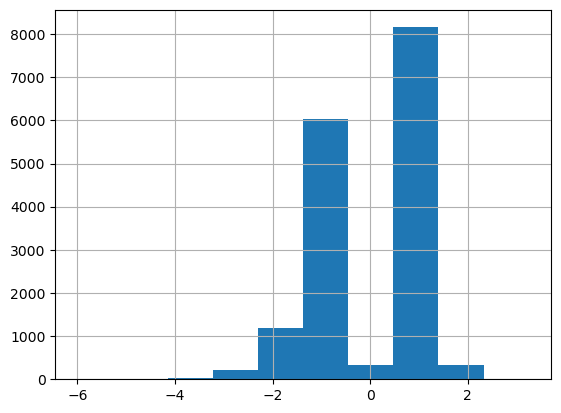

In [21]:
ips_expr_filt["EdgeR.log2FC"].hist()

In [132]:
def indexing_deg(lnc_ens, aso, up_or_down_expr, subdf, project_dir):
    to_index = Path(project_dir) / lnc_ens
    to_index.mkdir(exist_ok=True, parents=True)
    to_save = to_index / f"{lnc_ens}-{aso}-{up_or_down_expr}-.tsv.gz"
    subdf.to_csv(to_save, sep="\t", compression="gzip", index=False)    

In [23]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(indexing_deg)(lnc_ens, aso, up_or_down_expr, subdf, project_dir=IPS_INDEX)
        for (lnc_ens, aso, up_or_down_expr), subdf in ips_expr_filt.groupby(by=["target.geneID", "target.gapmerID", "up_or_down_expr"])
    )

In [24]:
#способ смотреть без разбиаения на up/down экспрессию
pd.concat([pd.read_csv(to_deg, sep="\t") for to_deg in IPS_INDEX.glob((f'*/*ENSG00000142396-G0142396_AD_01-*'))]).head()

,DEG.geneID,DEG.HGNC,EdgeR.log2FC,EdgeR.log2CPM,EdgeR.pvalue,EdgeR.FDR,EdgeR.Zscore,target.gapmerID,target.geneID,target.HGNC,up_or_down_expr
0,ENSG00000067113,PLPP1,-0.768020,6.016004,0.000133,0.032065,-2.639597,G0142396_AD_01,ENSG00000142396,ERVK3-1,down
1,ENSG00000071054,MAP4K4,-0.547953,7.187303,0.000127,0.031478,-3.879051,G0142396_AD_01,ENSG00000142396,ERVK3-1,down
2,ENSG00000078140,UBE2K,-0.536019,7.982436,0.000162,0.033866,-3.795072,G0142396_AD_01,ENSG00000142396,ERVK3-1,down
3,ENSG00000101856,PGRMC1,-0.601067,7.721209,0.000080,0.022462,-2.658966,G0142396_AD_01,ENSG00000142396,ERVK3-1,down
4,ENSG00000113269,RNF130,-0.778662,6.261279,0.000012,0.006001,-3.515180,G0142396_AD_01,ENSG00000142396,ERVK3-1,down


## fantom fibro deg

In [63]:
to_fibro = FIBRO / "DESeq2_genes_ASO_signif.tsv"
fibro_expr_pivot = pd.read_csv(to_fibro, sep="\t")
fibro_expr_pivot.head()

,geneID,geneSymbol,ASO_G0268895_01,ASO_G0268895_03,ASO_G0205485_01,ASO_G0205485_03,ASO_G0231185_02,ASO_G0231185_03,ASO_G0231312_02,ASO_G0231312_04,...,ASO_G0247240_AD_05,ASO_G0247240_AD_06,ASO_G0180769_03,ASO_G0180769_08,ASO_G0180769_AD_03,ASO_G0234420_01,ASO_G0230844_01,ASO_G0230844_AD_06,ASO_G0269293_01,ASO_G0269293_AD_10
0,ENSG00000200169,RNU5D-1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSG00000138675,FGF5,-1,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000252521,RNU5D-2P,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ENSG00000268895,A1BG-AS1,-1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CATG00000098831,CATG00000098831.1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
fibro_expr_pivot.shape

(16989, 342)

In [195]:
fibro_expr = pd.melt(fibro_expr_pivot, 
            id_vars='geneID', 
            value_vars=list(fibro_expr_pivot.columns[2:]), # list of days of the week
            var_name='target.gapmerID', 
            value_name='expr')
fibro_expr.rename(columns={"geneID":"DEG.geneID"}, inplace=True)

In [196]:
fibro_expr.head()

,DEG.geneID,target.gapmerID,expr
0,ENSG00000200169,ASO_G0268895_01,-1
1,ENSG00000138675,ASO_G0268895_01,-1
2,ENSG00000252521,ASO_G0268895_01,-1
3,ENSG00000268895,ASO_G0268895_01,-1
4,CATG00000098831,ASO_G0268895_01,1


In [197]:
fibro_expr.shape

(5776260, 3)

In [198]:
to_fibro_aso = FIBRO / "ASO_names.info"
fibro_aso = pd.read_csv(to_fibro_aso, sep="\t")
fibro_aso.head()

,aso_id,aso_id_short,prmtrID,prmtrName,trnscptID,trnscptName,trnscptType,geneID,geneName,geneType
0,ASO_C0000830_02,C0000830,CUFT00000000830.T0,chr1_50977446_50977745_+,p012@CDKN2C,CUFT00000000830.T0,__na,ENSG00000123080,CDKN2C,protein_coding
1,ASO_C0000830_08,C0000830,CUFT00000000830.T0,chr1_50977446_50977745_+,p012@CDKN2C,CUFT00000000830.T0,__na,ENSG00000123080,CDKN2C,protein_coding
2,ASO_C0008202_01,C0008202,CUFT00000008202.T0,chr4_183350680_183350979_-,p003@CLDN22,CUFT00000008202.T0,__na,ENSG00000177300,CLDN22,protein_coding
3,ASO_C0008202_02,C0008202,CUFT00000008202.T0,chr4_183350680_183350979_-,p003@CLDN22,CUFT00000008202.T0,__na,ENSG00000177300,CLDN22,protein_coding
4,ASO_C0008202_04,C0008202,CUFT00000008202.T0,chr4_183350680_183350979_-,p003@CLDN22,CUFT00000008202.T0,__na,ENSG00000177300,CLDN22,protein_coding


In [199]:
fibro_expr = pd.merge(left=fibro_expr, left_on="target.gapmerID",
         right=fibro_aso[["aso_id", "geneID"]], right_on="aso_id")
fibro_expr.rename(columns={"geneID":"target.geneID"}, inplace=True)

In [200]:
fibro_expr.shape

(5657337, 5)

In [201]:
mask = fibro_expr["expr"] == 0
fibro_expr_filt = fibro_expr[~mask]
fibro_expr_filt.head()

,DEG.geneID,target.gapmerID,expr,aso_id,target.geneID
0,ENSG00000200169,ASO_G0268895_01,-1,ASO_G0268895_01,ENSG00000268895
1,ENSG00000138675,ASO_G0268895_01,-1,ASO_G0268895_01,ENSG00000268895
2,ENSG00000252521,ASO_G0268895_01,-1,ASO_G0268895_01,ENSG00000268895
3,ENSG00000268895,ASO_G0268895_01,-1,ASO_G0268895_01,ENSG00000268895
4,CATG00000098831,ASO_G0268895_01,1,ASO_G0268895_01,ENSG00000268895


In [202]:
fibro_expr_filt.shape

(136566, 5)

In [203]:
fibro_expr_filt["up_or_down_expr"] = np.where(fibro_expr_filt["expr"] == 1, "up", "down")
fibro_expr_filt = fibro_expr_filt[["DEG.geneID", "target.gapmerID", "target.geneID", "up_or_down_expr"]]

/tmp/ipykernel_18082/951825703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fibro_expr_filt["up_or_down_expr"] = np.where(fibro_expr_filt["expr"] == 1, "up", "down")


In [204]:
fibro_expr_filt.head()

,DEG.geneID,target.gapmerID,target.geneID,up_or_down_expr
0,ENSG00000200169,ASO_G0268895_01,ENSG00000268895,down
1,ENSG00000138675,ASO_G0268895_01,ENSG00000268895,down
2,ENSG00000252521,ASO_G0268895_01,ENSG00000268895,down
3,ENSG00000268895,ASO_G0268895_01,ENSG00000268895,down
4,CATG00000098831,ASO_G0268895_01,ENSG00000268895,up


In [205]:
fibro_expr_filt.shape

(136566, 4)

In [206]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(indexing_deg)(lnc_ens, aso, up_or_down_expr, subdf, project_dir=FIBRO_INDEX)
        for (lnc_ens, aso, up_or_down_expr), subdf in fibro_expr_filt.groupby(by=["target.geneID", "target.gapmerID", "up_or_down_expr"])
    )

## fantom cat

In [25]:
fantom_lv2 = pd.read_csv(FANTOM / "FANTOM_CAT.lv2_permissive.info_table.gene.tsv.gz", sep="\t")

In [26]:
fantom_lv2.head()

,geneID,loc,strand,geneName,geneClass,geneCategory,DHS_type,geneType,exonLen_bin,splicingType,...,support_source_num,strongest_DPIClstrID,sum_spIndx,max_genomicLen,max_exonLen,TE_LINE_associated,TE_SINE_associated,TE_DNA_associated,TE_LTR_associated,annoComment
0,CATG00000000002.1,"chr1:953490-954359,+",+,CATG00000000002.1,coding_mRNA,__na,not_DHS,__na,bin3:500-1000nt,type1:unspliced,...,2,"chr1:953489..953490,+",0.0,870,870,no,no,no,yes,At least 1 of the 10 top ranked transcript is ...
1,CATG00000000003.1,"chr1:4721910-4724467,+",+,CATG00000000003.1,sense_overlap_RNA,__na,not_DHS,__na,bin5:>2000nt,type2:di-exonic,...,1,"chr1:4721909..4721910,+",0.0,2558,2545,yes,no,no,no,"sense overlapping with another gene, either DP..."
2,CATG00000000004.1,"chr1:47082703-47085276,+",+,CATG00000000004.1,lncRNA_divergent,p_lncRNA_divergent,DHS_promoter,__na,bin4:1000-2000nt,type1:unspliced,...,1,"chr1:47082699..47082703,+",0.0,1542,1542,no,no,no,no,"query_DPI = chr1:47082699..47082703,+;max_hit_..."
3,CATG00000000005.1,"chr10:70827747-70828440,-",-,CATG00000000005.1,lncRNA_intergenic,e_lncRNA,DHS_enhancer,__na,bin3:500-1000nt,type1:unspliced,...,1,"chr10:70828439..70828440,-",0.0,694,694,no,no,no,no,long non-coding RNA and at least 2000 nt from ...
4,CATG00000000006.1,"chr10:70829530-70830598,-",-,CATG00000000006.1,lncRNA_divergent,__na,not_DHS,__na,bin4:1000-2000nt,type1:unspliced,...,1,"chr10:70830593..70830614,-",0.0,1069,1069,no,no,no,no,"query_DPI = chr10:70830593..70830614,-;max_hit..."


In [27]:
fantom_lv2["geneID_without_v"] = fantom_lv2["geneID"].apply(lambda x: x.split(".")[0])

In [28]:
fantom_lv2.columns

Index(['geneID', 'loc', 'strand', 'geneName', 'geneClass', 'geneCategory',
       'DHS_type', 'geneType', 'exonLen_bin', 'splicingType', 'TIEScore_tier',
       'total_clstrCount', 'num_transcript', 'coding_status', 'directionality',
       'cumulative_support', 'support_source_num', 'strongest_DPIClstrID',
       'sum_spIndx', 'max_genomicLen', 'max_exonLen', 'TE_LINE_associated',
       'TE_SINE_associated', 'TE_DNA_associated', 'TE_LTR_associated',
       'annoComment', 'geneID_without_v'],
      dtype='object')

In [29]:
fantom_lv2_mapping = fantom_lv2[["geneID_without_v", "geneName"]].set_index("geneID_without_v")

In [30]:
len(fantom_lv2_mapping)

124245

## matrix

In [231]:
def create_matrix(to_deg, to_himorna, exp):
    deg_gene_ids = np.asarray(pd.read_csv(to_deg, sep="\t", usecols=["DEG.geneID"])["DEG.geneID"])
    corr_gene_ids = np.asarray(pd.read_csv(to_himorna, sep="\t", usecols=["gene_ens"])["gene_ens"])
    
    deg_mask = fantom_lv2["geneID_without_v"].isin(deg_gene_ids)
    corr_mask = fantom_lv2["geneID_without_v"].isin(corr_gene_ids)
    TP = deg_mask & corr_mask
    TN = deg_mask & ~corr_mask
    FP = ~deg_mask & corr_mask
    FN = ~(deg_mask | corr_mask)
    
    to_save = PREPROCESSING / f"{exp}_matrices" / to_himorna.name.split('-')[0] / f"{to_himorna.name.split('-')[1]}-{to_deg.name.split('-')[1]}-{to_himorna.name.split('-')[2]}-{to_deg.name.split('-')[2]}-.npy"
    if to_save.exists():
        print(f"Skipped: ({to_himorna.name.split('-')[0]}) {to_himorna.name.split('-')[1]} {to_deg.name.split('-')[1]} {to_himorna.name.split('-')[2]} {to_deg.name.split('-')[2]}")
        return
    to_save.parent.mkdir(exist_ok=True, parents=True)
    np.save(to_save, np.stack((TP, TN, FP, FN)))

In [ ]:
with Parallel(n_jobs=-1) as pool:
        chunks = pool(
            delayed(create_matrix)(to_deg, to_himorna, exp)
            for exp in ["fibro", "ips"]
            for to_deg in (PREPROCESSING / f"{exp}_deg_index").glob(('*/*.tsv.gz'))
            for corr_sign in ("plus", "minus")
            for to_himorna in HIMORNA_INDEX.glob(f'*/*-{to_deg.name.split("-")[0]}-{corr_sign}-.tsv.gz')
        )

## fisher exact test

In [33]:
def fisher_exact_test(to_matrice):
    matrice = np.sum(np.load(to_matrice), axis=1)
    fisher_exact_res = fisher_exact([[matrice[0], matrice[1]], 
                         [matrice[2], matrice[3]]], alternative='two-sided')
    return fisher_exact_res[1]
    #return matrice

In [34]:
def reshape_df(df):
    df['combination'] = df['corr_sign'] + '_' + df['up_or_down_expr']
    # Создание сводной таблицы
    pivot_df = df.pivot_table(index=['hm', 'lnc_ens', 'aso'], 
                              columns='combination', 
                              values='p_value', 
                              aggfunc='first').reset_index()
    # Заполнение NaN значений нулями или другими значениями по необходимости
    pivot_df = pivot_df.fillna(1)
    return pivot_df

In [255]:
def job(hm, exp):
    p_values = []
    lncrna = []
    aso = []
    corr_sign = []
    up_or_down_expr = []
    for to_matrice in (PREPROCESSING / f"{exp}_matrices" / hm).glob('*'):
        p_values.append(fisher_exact_test(to_matrice))
        lncrna.append(to_matrice.name.split("-")[0])
        aso.append(to_matrice.name.split("-")[1])
        corr_sign.append(to_matrice.name.split("-")[2])
        up_or_down_expr.append(to_matrice.name.split("-")[3])
    df = pd.DataFrame({"hm": [hm for i in range(len(p_values))],
                       "lnc_ens": lncrna,
                       "aso": aso,
                       "p_value": p_values,
                       "corr_sign": corr_sign,
                       "up_or_down_expr": up_or_down_expr
                      })
    df = reshape_df(df)
    p_value_md_adj_bonf = multipletests(df["minus_down"], method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)[1]
    df['p_value_md_adj'] = p_value_md_adj_bonf

    p_value_mu_adj_bonf = multipletests(df["minus_up"], method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)[1]
    df['p_value_mu_adj'] = p_value_mu_adj_bonf

    p_value_pd_adj_bonf = multipletests(df["plus_down"], method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)[1]
    df['p_value_pd_adj'] = p_value_pd_adj_bonf

    p_value_pu_adj_bonf = multipletests(df["plus_up"], method='fdr_bh', alpha=0.05, is_sorted=False, returnsorted=False)[1]
    df['p_value_pu_adj'] = p_value_pu_adj_bonf
    
    to_save = PREPROCESSING / f"{exp}_fisher_exact_test"  / f"{hm}.tsv"
    if to_save.exists():
        print(f"Skipped: {hm}")
        return
    to_save.parent.mkdir(exist_ok=True, parents=True)
    df.to_csv(to_save, sep="\t", index=False)

In [257]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(job)(hm=hm, exp=exp)
        for exp in ["fibro", "ips"]
        for hm in list_of_hm)

In [264]:
fisher_results_filt_by_exp = {}
usecols=["hm", "lnc_ens", "p_value_md_adj", "p_value_mu_adj", "p_value_pd_adj", "p_value_pu_adj"]
for exp in ["fibro", "ips"]:
    fisher_results = [pd.read_csv(to_df, usecols=usecols, sep="\t") for to_df in (PREPROCESSING / f"{exp}_fisher_exact_test").glob("*.tsv")]
    fisher_results = pd.concat(fisher_results).reset_index(drop=True)

    mask = np.where(
        (fisher_results["p_value_md_adj"] < 0.05) |
        (fisher_results["p_value_mu_adj"] < 0.05) |
        (fisher_results["p_value_pd_adj"] < 0.05) |
        (fisher_results["p_value_pu_adj"] < 0.05),
        True,
        False
    )
    fisher_results_filt = fisher_results[mask].rename(columns={"p_value_md_adj":"er", "p_value_mu_adj":"ea", "p_value_pd_adj":"wa", "p_value_pu_adj":"wr"})
    fisher_results_filt["lnc"] = fisher_results_filt["lnc_ens"].apply(lambda x: fantom_lv2_mapping.loc[x, "geneName"])
    fisher_results_filt_by_exp[exp] = fisher_results_filt

In [268]:
fisher_results_filt_by_exp["fibro"][fisher_results_filt_by_exp["fibro"]["hm"] == "H3K27ac"]

,hm,lnc_ens,er,ea,wa,wr,lnc
512,H3K27ac,ENSG00000204054,2.071150e-27,3.167324e-08,6.196324e-17,5.582254e-03,LINC00963
514,H3K27ac,ENSG00000205181,2.121283e-09,1.000000e+00,1.642379e-05,1.000000e+00,LINC00654
515,H3K27ac,ENSG00000212978,2.797736e-05,1.000000e+00,7.060086e-10,1.000000e+00,AC016747.3
516,H3K27ac,ENSG00000212978,1.000000e+00,5.125705e-02,5.823195e-05,9.878911e-02,AC016747.3
517,H3K27ac,ENSG00000212978,1.088284e-26,2.466738e-12,3.363906e-38,1.000000e+00,AC016747.3
518,H3K27ac,ENSG00000214548,7.650625e-37,1.417677e-42,2.539066e-31,2.134966e-19,MEG3
519,H3K27ac,ENSG00000214548,3.031242e-17,1.685811e-85,2.877479e-16,2.628915e-35,MEG3
523,H3K27ac,ENSG00000223485,5.147103e-166,1.902972e-08,1.348027e-140,1.195463e-01,RP11-417E7.1
524,H3K27ac,ENSG00000223485,2.513501e-123,6.912990e-22,7.042364e-73,1.799775e-17,RP11-417E7.1
531,H3K27ac,ENSG00000225733,3.501909e-05,1.136113e-03,1.634527e-07,2.531922e-08,FGD5-AS1


## heatmap

https://github.com/vanya-antonov/article-himorna-and-f6/blob/main/src/four_roles.ipynb
pm => wa
1st "p" => positive correlation between lncRNA and the level of a histone mark => lncRNA writes the mark => writer (w)

2nd "m" => after lncRNA knockdown the expression of a nearby gene decreases => in normal cells (i.e. without knockdown) lncRNA upregulates expression of the gene.

Taking into account that lncRNA is writer, the only way it can upregulate gene expression is that it writes an active mark => its molecular role is "Writer of an Active mark (wa)"

pp => wr
1st "p" => positive correlation between lncRNA and the level of a histone mark => lncRNA writes the mark => writer (w)

2nd "p" => after lncRNA knockdown the expression of a nearby gene increases => in normal cells (i.e. without knockdown) lncRNA downregulates expression of the gene.

Taking into account that lncRNA is writer, the only way it can downregulate gene expression is that it writes a repressive mark => its molecular role is "Writer of a Repressive mark (wr)"

mp => ea
1st "m" => negative correlation between lncRNA and the level of a histone mark => lncRNA removes the mark => eraser (e)

2nd "p" => after lncRNA knockdown the expression of a nearby gene increases => in normal cells (i.e. without knockdown) lncRNA downregulates expression of the gene.

Taking into account that lncRNA is eraser, the only way it can downregulate gene expression is that it erases an active mark => its molecular role is "Eraser of an Active mark (ea)"

mm => er
1st "m" => negative correlation between lncRNA and the level of a histone mark => lncRNA removes the mark => eraser (e)

2nd "m" => after lncRNA knockdown the expression of a nearby gene decreases => in normal cells (i.e. without knockdown) lncRNA upregulates expression of the gene.

Taking into account that lncRNA is eraser, the only way it can upregulate gene expression is that it removes repressive mark => its molecular role is "Eraser of a Repressive mark (er)"

In [263]:
def heatmap(df, exp):
    df_for_heatmap = pd.pivot_table(data=df[["hm","lnc","er","ea","wa","wr"]], index=["lnc"], columns="hm", aggfunc="min").map(lambda x: 1 if x <= 0.05 else 0)
    fig, ax = plt.subplots(1, 1, figsize=(15, 8), sharey=True)
    heatmap = sns.heatmap(df_for_heatmap.sort_index(axis=1, level=1), linewidths=.3, cmap='Oranges', annot=False).set_title(f"Heatmap for {exp}")
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    plt.xticks(rotation=90)
    plt.show()    

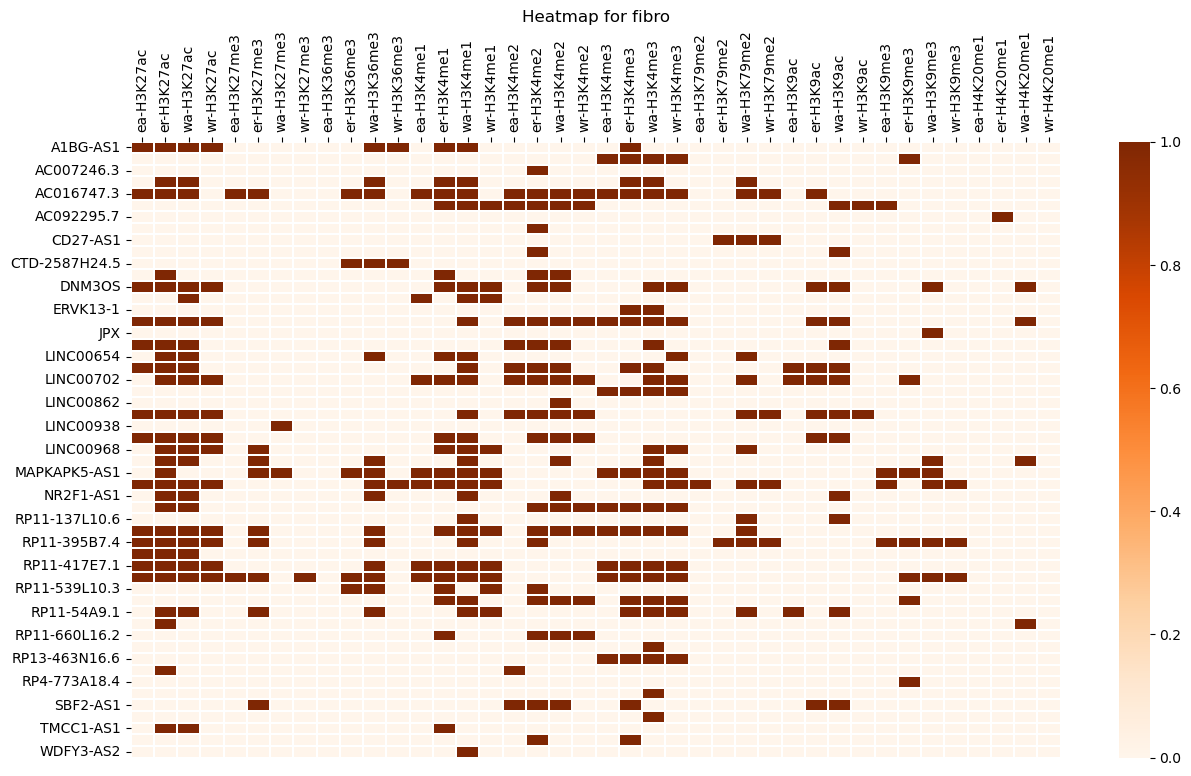

In [266]:
heatmap(fisher_results_filt_by_exp["fibro"], "fibro")

## Pubmed

In [41]:
# Установка адреса электронной почты, необходимого для использования API PubMed
Entrez.email = "m.agletdinov2018@gmail.com"

def search_pubmed(query):
    # Поиск статей по запросу
    handle = Entrez.esearch(db="pubmed", term=query, retmax=10)
    record = Entrez.read(handle)
    handle.close()
    return record

def fetch_abstract(pmid):
    # Получение абстракта статьи по ее PubMed ID (PMID)
    handle = Entrez.efetch(db="pubmed", id=pmid, rettype="abstract", retmode="text")
    abstract = handle.read()
    handle.close()
    return abstract.replace("\n","")

pubmed_res = defaultdict(list)
for query in fisher_results_filt["lnc"].unique():
    print(f"{query}\n")
    record = search_pubmed(query)
    for pmid in record["IdList"]:
        abstract = fetch_abstract(pmid)
        print("\tPubMed ID:", pmid)
        pubmed_res[query].append([pmid, abstract])

RP3-510D11.2

MAPKAPK5-AS1

	PubMed ID: 38846329
	PubMed ID: 38225924
	PubMed ID: 37154079
	PubMed ID: 36867352
	PubMed ID: 36567178
	PubMed ID: 36510238
	PubMed ID: 36445573
	PubMed ID: 36379256
	PubMed ID: 36009801
	PubMed ID: 35674862
LINC01021

	PubMed ID: 38730591
	PubMed ID: 36342127
	PubMed ID: 35173309
	PubMed ID: 35012438
	PubMed ID: 34469433
	PubMed ID: 34026327
	PubMed ID: 32774710
	PubMed ID: 32774475
	PubMed ID: 29262524
	PubMed ID: 28877474
RP1-46F2.2

EPHA1-AS1

	PubMed ID: 38003532
	PubMed ID: 33516273
RP11-421L21.3

LINC00173

	PubMed ID: 38705575
	PubMed ID: 38182665
	PubMed ID: 38069335
	PubMed ID: 37365917
	PubMed ID: 37258811
	PubMed ID: 37081063
	PubMed ID: 36894691
	PubMed ID: 36856154
	PubMed ID: 36774758
	PubMed ID: 36627670
AC016747.3

	PubMed ID: 34735975
AC002310.12

SBF2-AS1

	PubMed ID: 38279439
	PubMed ID: 37593490
	PubMed ID: 37538086
	PubMed ID: 37445702
	PubMed ID: 37286777
	PubMed ID: 37131869
	PubMed ID: 37072750
	PubMed ID: 36927189
	PubMed ID: 3681

In [42]:
pubmed_res.keys()

dict_keys(['MAPKAPK5-AS1', 'LINC01021', 'EPHA1-AS1', 'LINC00173', 'AC016747.3', 'SBF2-AS1', 'OIP5-AS1', 'AC007255.8', 'AC009299.3', 'LINC00883'])

In [ ]:
# считать попроавку для подслучаев также, как и для всех. По меткам